In [81]:
%load_ext autoreload
%autoreload 2
from clustering.herdingspikes import *
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [82]:
#O = spikeclass('test_datasets/P38part_for_git_2.hdf5') # this loads a file that was saved by the class itself
O = ImportInterpolated('/data/MEA/LightStim/P29_16_07_14/HdfFilesSpkD45_Fullsample_LSpike4/P29_16_05_14_retina01_right_stim2_smallarray_fullfield_SpkD45_v18.hdf5',shapesupto=57) #if reading a normal file


Based on 34 examples of bad shapes.
Based on 4469 examples of good shapes.


/home/mhennig/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


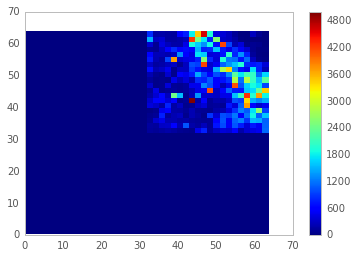

In [83]:
data = O.Locations()
threshold = 10
nbins = [40,40]
gthres = 10
hg,bx,by = np.histogram2d(data[0],data[1],nbins)
plt.pcolor(bx,by,hg)
plt.colorbar()

binspanx = (np.max(data[0])-np.min(data[0]))/nbins[0]*1.001
binspany = (np.max(data[1])-np.min(data[1]))/nbins[1]*1.001
nbx = ((data[0]-np.min(data[0]))//binspanx).astype(int)
nby = ((data[1]-np.min(data[1]))//binspany).astype(int)
ind = np.where(hg[nbx,nby]<=threshold)[0]
print "Based on "+str(len(ind))+" examples of bad shapes."
normalise = lambda X: X/np.max(np.abs(X),axis=0)
badshape = np.nanmean(normalise(O.Shapes()[:,ind]),axis=1)
fakeampl = np.max(np.abs(O.Shapes()),axis=0)
ind = np.where(fakeampl>gthres)[0]
print "Based on "+str(len(ind))+" examples of good shapes."
goodshape = np.mean(normalise(O.Shapes()[:,ind]),axis=1)

classifier = .5*(goodshape-badshape)


[-0.06580845 -0.06856249 -0.21119164 -0.30258006 -0.34273043 -0.62323701
 -0.76340646 -0.75683981 -0.60076708 -0.35450229 -0.26816094 -0.30396912
 -0.2300652  -0.16472775 -0.20253789 -0.20367068 -0.16794974 -0.2144452
 -0.10360538 -0.16048187 -0.19304176 -0.19358104 -0.15873931 -0.20592433
 -0.14660643 -0.11697217 -0.16799495 -0.09583601 -0.11784071 -0.19892327
 -0.09967896 -0.15818971 -0.10249505 -0.09020665 -0.10188466 -0.16298817
 -0.10671301 -0.10224903 -0.08575952 -0.13209997 -0.12348814 -0.1498118
 -0.04249173 -0.05369783 -0.03544541 -0.13439775 -0.10123079 -0.07972971
 -0.10783852 -0.07940189  0.01638051 -0.11613206 -0.11870521 -0.13425319
 -0.07932226 -0.11760633 -0.06766729]


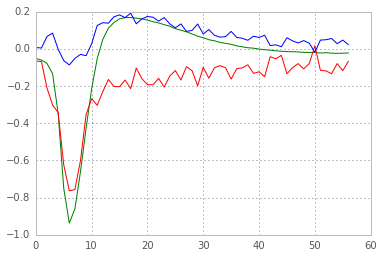

In [84]:
print badshape
fig,ax=subplots()
ax.plot(goodshape,'g')
ax.plot(badshape,'r')
ax.plot(classifier,'b')

Starting sklearn PCA... done.
(307779,) (307779,)


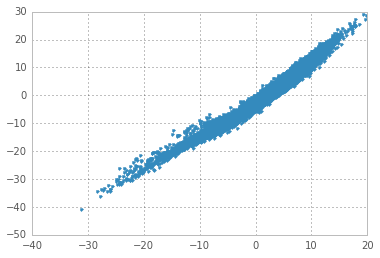

In [85]:
#O.Crop(4.,7.,54.,58.)
score = np.dot(classifier,(O.Shapes())) #can be normalised or not!
#print O.Shapes().shape
#p = PCA(n_components=1,whiten=False)
#scorePCA = p.fit_transform(O.Shapes().T).T

scorePCA = O.ShapePCA(ncomp=1)[0]
print score.shape,scorePCA.shape
plt.plot(score,scorePCA,'.')

There is a !very! good correlation between the first PC and the "score" obtained by bad and good examples, which is promising.

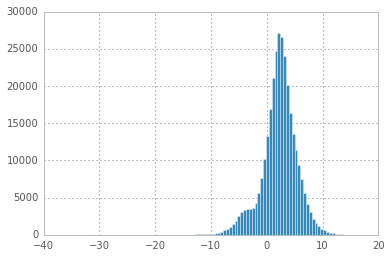

In [86]:
plt.hist(score,100);

This time the score histogram is bi-modal!

In [87]:
O.CombinedMeanShift(0.3,0.25) # was 0.15

Starting sklearn PCA... done.
Starting sklearn Mean Shift...  done.


Number of remaining clusters:  13804


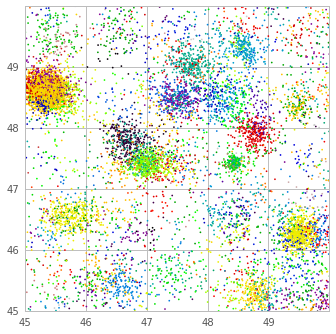

In [88]:
#O.FilterSmallClusters(100)
O.PartPlot(45.,50.,45.,50.)
print "Number of remaining clusters: ",O.NClusters()

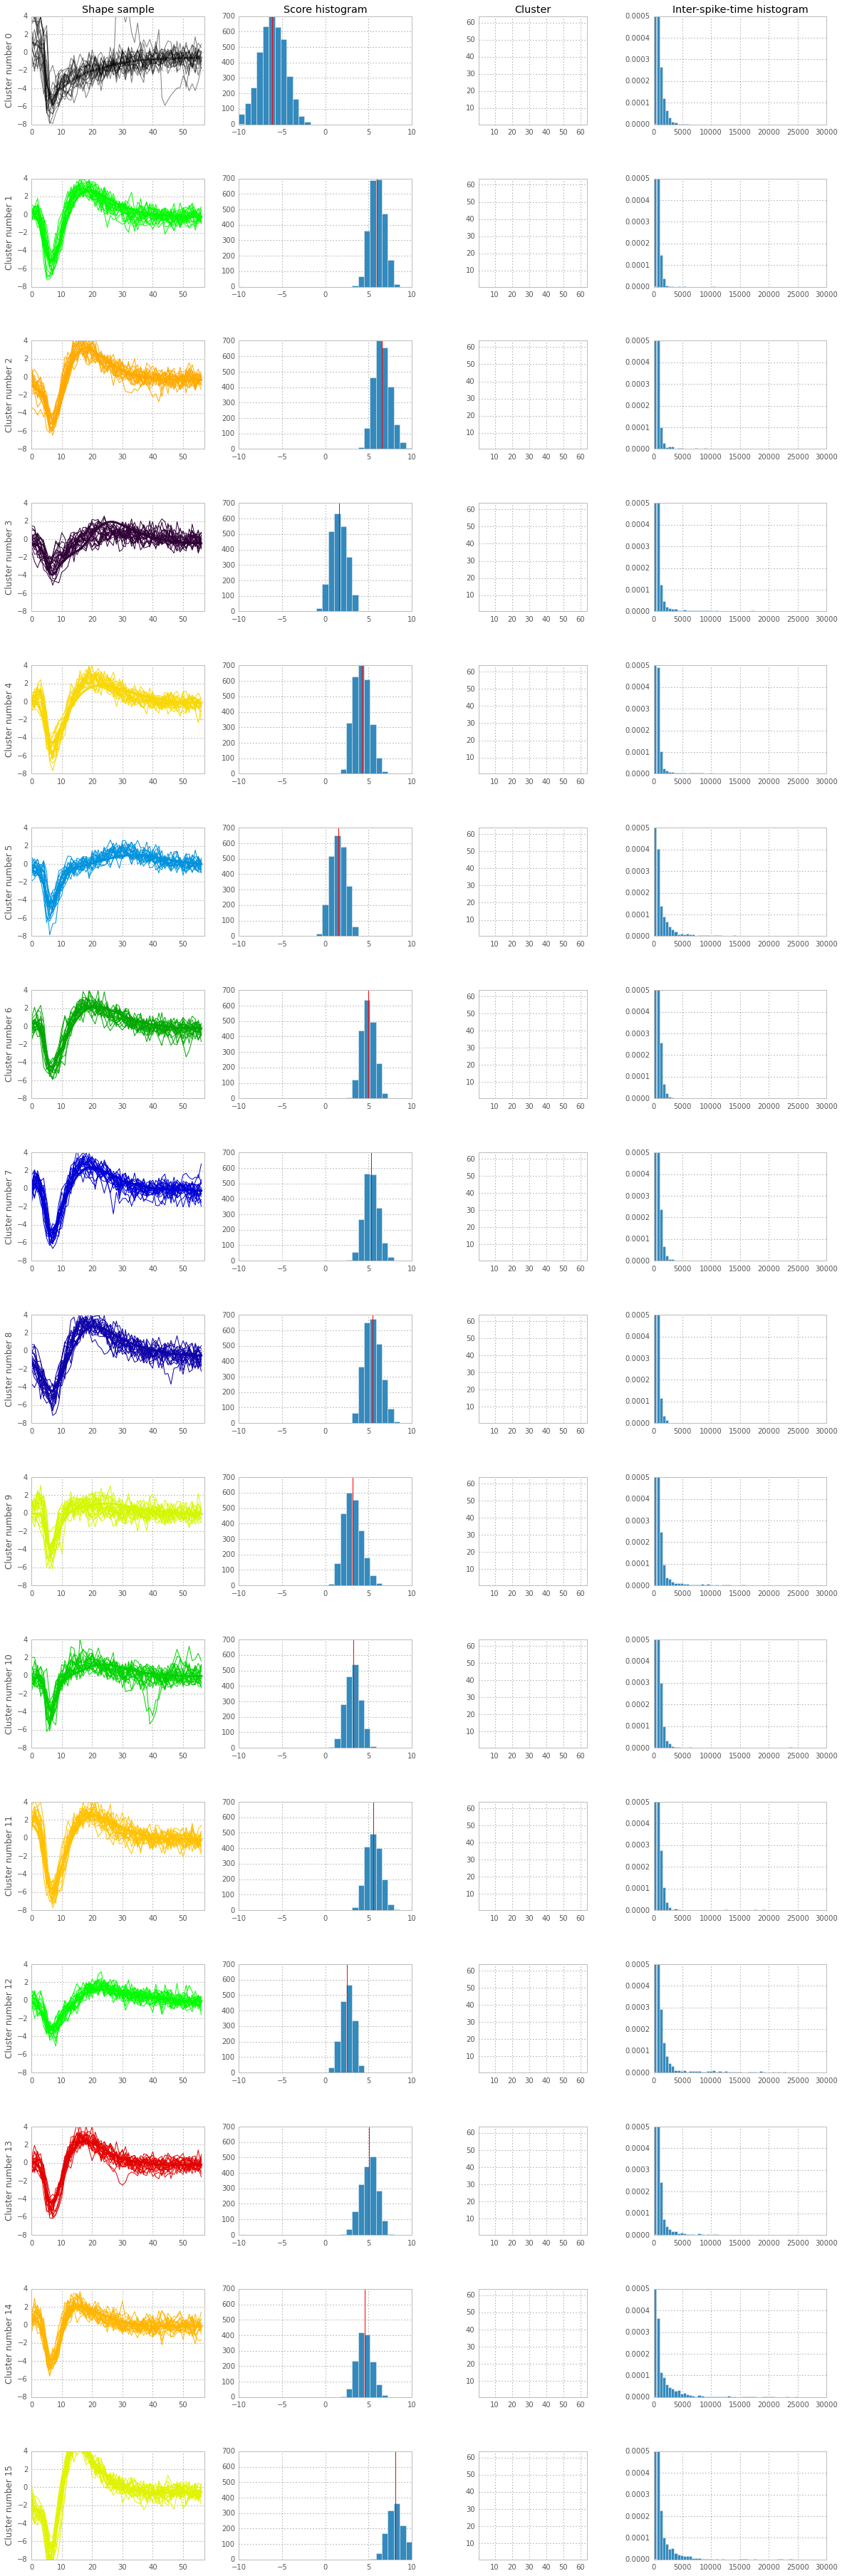

In [89]:
avgshapes = array(map(lambda cl: mean(O.Shapes()[:,O.ClusterID()==cl],axis=1),range(O.NClusters()))).T
clscore = np.dot(classifier,(avgshapes))

clusters = range(O.NClusters())[:16]

fig,ax=subplots(len(clusters),4,figsize=(20,4*len(clusters)))
for n,cluster in enumerate(clusters):
    ind = O.ClusterID()==cluster
    col = O.Colours()[cluster]
    ax[n,0].plot(O.Shapes()[:,ind][:,:20],c=col)
    ax[n,0].set_ylabel('Cluster number '+str(cluster))
    ax[n,0].set_xlim([0,57])
    ax[n,0].set_ylim([-8,4])
    ax[n,0].plot(mean(O.Shapes()[:,ind],axis=1),c=col,linewidth=3)
    clscores = score[ind]
    ax[n,1].hist(clscores,linspace(-10,10,30));
    ax[n,1].set_ylim([0,700])
    ax[n,1].axvline(x=clscore[cluster],color='r')
    data = O.Locations()
    ax[n,2].plot(data[0,-ind],data[1,-ind],',b')
    ax[n,2].plot(data[0,ind],data[1,ind],',r')
    ax[n,2].set_xlim([min(O.Locations()[0]),max(O.Locations()[0])]);
    ax[n,2].set_ylim([min(O.Locations()[1]),max(O.Locations()[1])]);
    ax[n,2].set_aspect('equal')
    timesinc = O.Times()[ind]
    deltat = timesinc[1:]-timesinc[:-1]
    ax[n,3].hist(deltat,linspace(0,25000,50),normed=True)
    ax[n,3].set_ylim([0,5e-4])
ax[0,0].set_title("Shape sample");
ax[0,1].set_title("Score histogram");
ax[0,2].set_title("Cluster");
ax[0,3].set_title("Inter-spike-time histogram");

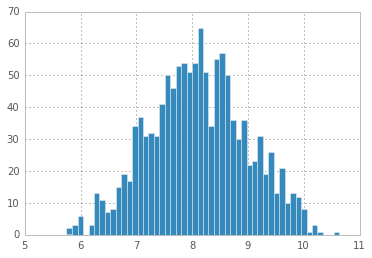

In [90]:
hist(clscores,50);

In [154]:
#save for enas
string = ''
times= O.Times()
cid = O.ClusterID()
for i in range(len(cid)):
    string += str(times[i])+" "+str(cid[i])+"\n"
    
with open("test.txt", "wt") as out_file:
    out_file.write(string)